# Prepare dataset

In [1]:
!pip install torch torchvision --quiet


from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
TARGET_SIZE = (256, 256)

def resize_image(image):
    # image : numpy array ou PIL.Image
    if isinstance(image, np.ndarray):
        # Convert numpy array to PIL Image
        image = Image.fromarray(image)
    # Resize avec PIL
    resized = image.resize(TARGET_SIZE, resample=Image.BILINEAR)
    return np.array(resized)

def mask_split_threshold(image):
    # image numpy float ou uint8
    image = image.astype(np.float32)
    scaled = image / 255.0
    return scaled

def remove_padding(image):
    # image numpy (H,W) ou (H,W,C)
    if image.ndim == 3:
        gray = np.array(Image.fromarray(image).convert('L'))
    else:
        gray = image
    coords = np.argwhere(gray > 0)
    if coords.size > 0:
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        cropped = image[y_min:y_max+1, x_min:x_max+1]
        # Resize cropped à TARGET_SIZE
        cropped_img = Image.fromarray(cropped)
        cropped_resized = cropped_img.resize(TARGET_SIZE, resample=Image.BILINEAR)
        return np.array(cropped_resized)
    else:
        img = Image.fromarray(image)
        return np.array(img.resize(TARGET_SIZE, resample=Image.BILINEAR))

def preprocess_image(pil_image):
    image = np.array(pil_image)
    image = resize_image(image)
    image = remove_padding(image)
    image = mask_split_threshold(image)
    return image


class WaterBodyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        
        image = preprocess_image(image)
        mask = preprocess_image(mask)
        
        image = torch.tensor(image).permute(2, 0, 1).float()
        mask = torch.tensor(mask).unsqueeze(0).float()
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [3]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

In [4]:
# Prepare training

# Get images
images_dir = os.path.expanduser('~/work/Neural_Networks_for_Water_Body_Segmentation/Water_Bodies_Dataset/Images')
masks_dir = os.path.expanduser('~/work/Neural_Networks_for_Water_Body_Segmentation/Water_Bodies_Dataset/Masks')

image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])
mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])

image_paths = [os.path.join(images_dir, f) for f in image_files]
mask_paths = [os.path.join(masks_dir, f) for f in mask_files]


# Build train and test sets
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)


# Generate data loader
image_size = (256, 256)

train_dataset = WaterBodyDataset(train_imgs, train_masks)
val_dataset = WaterBodyDataset(val_imgs, val_masks)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

# Build the architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AAConvBlock(nn.Module):
    """
    Convolution block with Attention-Aware convolution: 
    Conv2d + Attention (SE-like) + BatchNorm + ReLU
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, reduction=16):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Lightweight Channel Attention (Squeeze-Excitation)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(out_channels, out_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(out_channels // reduction, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)

        # Attention part
        w = self.global_pool(out)
        w = self.relu(self.fc1(w))
        w = self.sigmoid(self.fc2(w))
        out = out * w  # channel-wise attention

        return out

class UNetAA(nn.Module):
    """U-Net architecture with AA-Conv blocks"""
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.filters = [32, 64, 128]

        # Encoder
        self.encoder1 = AAConvBlock(in_channels, self.filters[0])
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = AAConvBlock(self.filters[0], self.filters[1])
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = AAConvBlock(self.filters[1], self.filters[2])
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = AAConvBlock(self.filters[2], 256)

        # Decoder
        self.up3 = nn.ConvTranspose2d(256, self.filters[2], kernel_size=2, stride=2)
        self.decoder3 = AAConvBlock(self.filters[2]*2, self.filters[2])

        self.up2 = nn.ConvTranspose2d(self.filters[2], self.filters[1], kernel_size=2, stride=2)
        self.decoder2 = AAConvBlock(self.filters[1]*2, self.filters[1])

        self.up1 = nn.ConvTranspose2d(self.filters[1], self.filters[0], kernel_size=2, stride=2)
        self.decoder1 = AAConvBlock(self.filters[0]*2, self.filters[0])

        # Output
        self.final_conv = nn.Conv2d(self.filters[0], out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        p1 = self.pool1(e1)

        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)

        e3 = self.encoder3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        d3 = self.up3(b)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.decoder1(d1)

        out = self.final_conv(d1)
        return out


# Training

In [6]:
model = UNetAA()
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_preds = []
    train_targets = []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for imgs, masks in loop:
        imgs = imgs.to(device)
        masks = masks.to(device).float()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        train_preds.append(preds.cpu().numpy().flatten())
        train_targets.append(masks.cpu().numpy().flatten())

        preds_np = np.concatenate(train_preds)
        targets_np = (np.concatenate(train_targets) > 0.5).astype(np.float32)
        acc = accuracy_score(targets_np, preds_np)
        loop.set_postfix(loss=np.mean(train_losses), accuracy=acc)

    # evaluate the model after each epoch
    model.eval()
    val_losses = []
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device).float()

            outputs = model(imgs)
            val_loss = criterion(outputs, masks)
            val_losses.append(val_loss.item())

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            val_preds.append(preds.cpu().numpy().flatten())
            val_targets.append(masks.cpu().numpy().flatten())

    val_loss_avg = np.mean(val_losses)
    val_preds_np = np.concatenate(val_preds)
    val_targets_np = (np.concatenate(val_targets) > 0.5).astype(np.float32)
    val_acc = accuracy_score(val_targets_np, val_preds_np)

    print(f"Epoch {epoch+1} - Train Loss: {np.mean(train_losses):.4f} - Train Acc: {acc:.4f} - Val Loss: {val_loss_avg:.4f} - Val Acc: {val_acc:.4f}")

Epoch 1/10 [Train]: 100%|██████████| 568/568 [17:18<00:00,  1.83s/it, accuracy=0.719, loss=0.585]


Epoch 1 - Train Loss: 0.5849 - Train Acc: 0.7190 - Val Loss: 0.5408 - Val Acc: 0.7557


Epoch 2/10 [Train]: 100%|██████████| 568/568 [17:14<00:00,  1.82s/it, accuracy=0.79, loss=0.497] 


Epoch 2 - Train Loss: 0.4974 - Train Acc: 0.7900 - Val Loss: 0.4429 - Val Acc: 0.8242


Epoch 3/10 [Train]: 100%|██████████| 568/568 [16:39<00:00,  1.76s/it, accuracy=0.809, loss=0.456]


Epoch 3 - Train Loss: 0.4559 - Train Acc: 0.8090 - Val Loss: 0.4380 - Val Acc: 0.8178


Epoch 4/10 [Train]: 100%|██████████| 568/568 [18:02<00:00,  1.91s/it, accuracy=0.821, loss=0.431]


Epoch 4 - Train Loss: 0.4309 - Train Acc: 0.8213 - Val Loss: 0.4013 - Val Acc: 0.8356


Epoch 5/10 [Train]: 100%|██████████| 568/568 [18:32<00:00,  1.96s/it, accuracy=0.823, loss=0.418]


Epoch 5 - Train Loss: 0.4183 - Train Acc: 0.8232 - Val Loss: 0.3766 - Val Acc: 0.8498


Epoch 6/10 [Train]: 100%|██████████| 568/568 [16:57<00:00,  1.79s/it, accuracy=0.83, loss=0.41]  


Epoch 6 - Train Loss: 0.4101 - Train Acc: 0.8300 - Val Loss: 0.3991 - Val Acc: 0.8315


Epoch 7/10 [Train]: 100%|██████████| 568/568 [19:10<00:00,  2.03s/it, accuracy=0.837, loss=0.396]


Epoch 7 - Train Loss: 0.3960 - Train Acc: 0.8366 - Val Loss: 0.3669 - Val Acc: 0.8482


Epoch 8/10 [Train]: 100%|██████████| 568/568 [19:32<00:00,  2.06s/it, accuracy=0.837, loss=0.396]


Epoch 8 - Train Loss: 0.3959 - Train Acc: 0.8369 - Val Loss: 0.3640 - Val Acc: 0.8513


Epoch 9/10 [Train]: 100%|██████████| 568/568 [15:50<00:00,  1.67s/it, accuracy=0.843, loss=0.384]


Epoch 9 - Train Loss: 0.3835 - Train Acc: 0.8431 - Val Loss: 0.3570 - Val Acc: 0.8529


Epoch 10/10 [Train]: 100%|██████████| 568/568 [15:54<00:00,  1.68s/it, accuracy=0.845, loss=0.383]


Epoch 10 - Train Loss: 0.3830 - Train Acc: 0.8446 - Val Loss: 0.3578 - Val Acc: 0.8532


# Evaluation

In [7]:
from sklearn.metrics import jaccard_score

model.eval()
criterion = torch.nn.BCEWithLogitsLoss()

val_losses = []
val_preds = []
val_targets = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device).float()

        outputs = model(imgs)
        loss = criterion(outputs, masks)
        val_losses.append(loss.item())

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        val_preds.append(preds.cpu().numpy().flatten())
        val_targets.append(masks.cpu().numpy().flatten())

val_loss_avg = np.mean(val_losses)
val_preds_np = np.concatenate(val_preds)
val_targets_np = (np.concatenate(val_targets) > 0.5).astype(np.float32)

val_acc = accuracy_score(val_targets_np, val_preds_np)
val_precision = precision_score(val_targets_np, val_preds_np)
val_recall = recall_score(val_targets_np, val_preds_np)
val_f1 = f1_score(val_targets_np, val_preds_np)
val_iou = jaccard_score(val_targets_np, val_preds_np)

print(f"Validation Loss: {val_loss_avg:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print(f"Validation IoU Score: {val_iou:.4f}")

Validation Loss: 0.3578
Validation Accuracy: 0.8532
Validation Precision: 0.8207
Validation Recall: 0.7293
Validation F1 Score: 0.7723
Validation IoU Score: 0.6290


# Predictions

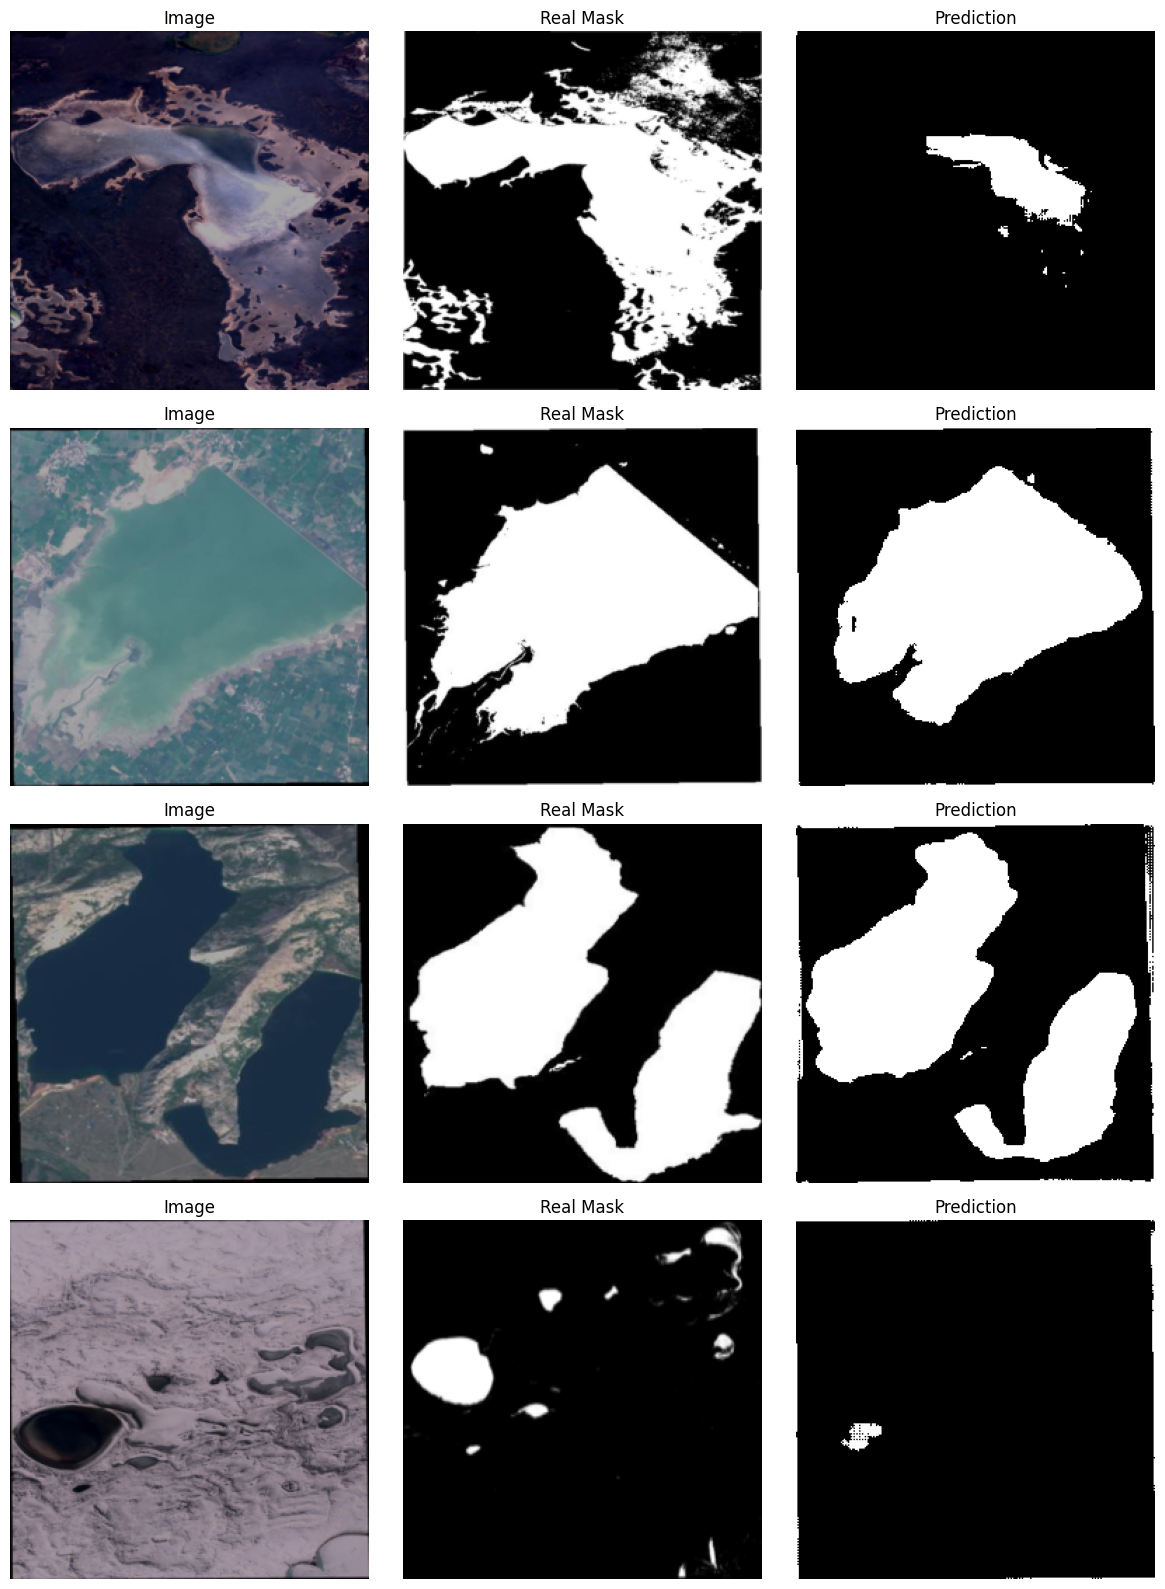

In [8]:
model.eval()
num_images_to_show = 4
images_shown = 0
rows = num_images_to_show
cols = 3

fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows))

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device).float()
        outputs = model(imgs)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        batch_size = imgs.size(0)
        for i in range(batch_size):
            if images_shown >= num_images_to_show:
                break

            axs[images_shown][0].imshow(imgs[i].cpu().permute(1, 2, 0))
            axs[images_shown][0].set_title("Image")
            axs[images_shown][0].axis('off')

            axs[images_shown][1].imshow(masks[i].cpu().squeeze(), cmap='gray')
            axs[images_shown][1].set_title("Real Mask")
            axs[images_shown][1].axis('off')

            axs[images_shown][2].imshow(preds[i].cpu().squeeze(), cmap='gray')
            axs[images_shown][2].set_title("Prediction")
            axs[images_shown][2].axis('off')

            images_shown += 1

        if images_shown >= num_images_to_show:
            break

plt.tight_layout()
plt.show()